In [ ]:
#from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List of interested Symbols
INTERESTED_SYMBOLS = ['A', 'AAPL', 'ACIU', 'AGYS', 'ALIM', 'AMPE', 'AMZN', 'APH', 'AXP', 'BA', 'BCM', 'BH', 'BNDX',
                      'BRID', 'CAT', 'CC', 'CLMB', 'CNET', 'COWZ', 'CSCO', 'CVCY', 'CVX', 'DIS', 'DIVB', 'DVAX',
                      'EHTH', 'ENG', 'ERJ', 'FOR', 'FXE', 'GE', 'GOOGL', 'GS', 'HD', 'HIW', 'HYDW', 'IBM', 'IGEB',
                      'IMRN', 'INTC', 'ISTR', 'IXP', 'JJC', 'JNJ', 'JPM', 'KIQ', 'KO', 'KT', 'LIT', 'MCD', 'MD',
                      'MGRC', 'MMIN', 'MMM', 'MPWR', 'MRK', 'MSFT', 'MTP', 'NKE', 'NWG', 'OCX', 'PBLA', 'PETS', 'PFE',
                      'PG', 'PML', 'PSMC', 'PXF', 'RRX', 'SCHB', 'SNCR', 'SPFF', 'SRDX', 'SXI', 'TGNA', 'TMFC', 'TRV',
                      'UGP', 'UNH', 'UTX', 'VBND', 'VOX', 'VXF', 'VZ', 'WMT', 'WSBC', 'XHS', 'XOM', 'XWEL', 'ZLAB']

PATH = "/content/drive/MyDrive/DependableAI/Project/Data/"

# Load the stock price data for all interested symbol
years  = ["2018", "2019", "2020", "2021", "2022"]
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

market_data = {}

for sym in INTERESTED_SYMBOLS:
    for y in years:
        for m in months:
            csv_file = PATH + y + "/" + m + "/" + sym + ".csv"
            data = pd.read_csv(csv_file,
                               names=["index", "date", "open", "high", "low", "close", "adjusted_close", "volume",
                                      "dividend_amount", "split_coefficient"])
            data = data.tail(-1)
            data = data[data.columns[1:]]
            data.set_index('date', inplace=True)
            data.index = pd.DatetimeIndex(data.index).to_period('D')
            if sym in market_data.keys():
                market_data[sym] = pd.concat([market_data[sym], data])
            else:
                market_data[sym] = data
    print(sym)


A
AAPL
ACIU
AGYS
ALIM
AMPE
AMZN
APH
AXP
BA
BCM
BH
BNDX
BRID
CAT
CC
CLMB
CNET
COWZ
CSCO
CVCY
CVX
DIS
DIVB
DVAX
EHTH
ENG
ERJ
FOR
FXE
GE
GOOGL
GS
HD
HIW
HYDW
IBM
IGEB
IMRN
INTC
ISTR
IXP
JJC
JNJ
JPM
KIQ
KO
KT
LIT
MCD
MD
MGRC
MMIN
MMM
MPWR
MRK
MSFT
MTP
NKE
NWG
OCX
PBLA
PETS
PFE
PG
PML
PSMC
PXF
RRX
SCHB
SNCR
SPFF
SRDX
SXI
TGNA
TMFC
TRV
UGP
UNH
UTX
VBND
VOX
VXF
VZ
WMT
WSBC
XHS
XOM
XWEL
ZLAB


In [ ]:
#plot close price
for sym in INTERESTED_SYMBOLS:
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Prices')
    plt.plot(market_data[sym].close.to_list(), label="close")
    plt.title(sym + ' open & close price')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Add Labels for the close prices
for sym in INTERESTED_SYMBOLS:
    df = market_data[sym]
    # Add Labels to close prices
    labels = []
    prev_close = 0
    close_prices = df['close'].to_list()
    for cp in close_prices:
        if prev_close == "":
            labels.append(0)
            prev_close = cp
        else:
            curr_close = cp
            if curr_close > prev_close + 0.050*prev_close:
                labels.append(1)
            elif curr_close < prev_close + 0.055*prev_close:
                labels.append(-1)
            else:
                labels.append(0)

    df['label'] = labels
    market_data[sym] = df

In [ ]:
from sklearn.model_selection import train_test_split

import pickle

# Training data len
train_len = int(len(market_data['A']) * 0.80)

actual_predictions = {}

for sym in INTERESTED_SYMBOLS:
    df = market_data[sym]
    open_prices  = df['open'].values.reshape(-1, 1)
    close_prices = df['close'].values.reshape(-1, 1)
    labels       = df['label'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0,1))
    close_prices_norm = scaler.fit_transform(close_prices)
    open_prices_norm  = scaler.fit_transform(open_prices)

    look_back = 30
    X_train = []
    y_train = []

    for i in range(look_back, train_len):
        open_prices_slice = open_prices_norm[i-look_back:i, 0]
        labels_slice = labels[i-look_back:i, 0]
        close_prices_slice = close_prices_norm[i-look_back:i, 0]
        X_train.append(np.column_stack((open_prices_slice, labels_slice)))
        y_train.append(close_prices_slice)
    
    X_test = []
    y_test = []
    
    for i in range(train_len, len(open_prices)):
        open_prices_slice = open_prices_norm[i-look_back:i, 0]
        labels_slice = labels[i-look_back:i, 0]
        close_prices_slice = close_prices_norm[i-look_back:i, 0]
        X_test.append(np.column_stack((open_prices_slice, labels_slice)))
        y_test.append(close_prices_slice)

    X_train = np.array(X_train).reshape(-1, look_back, 2)
    X_test  = np.array(X_test).reshape(-1, look_back, 2)
    y_train = np.array(y_train)
    y_test  = np.array(y_test)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 2)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=10, epochs=30)
    
    # Get the models predicted price values
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual_predictions[sym] = predictions
    test_indexes = list(df.index.values)[train_len:]
    sym_predictions = {}
    i = 0
    for ind in test_indexes:
        sym_predictions[ind] = predictions[i]
        i = i+1
    predict_file = "/content/drive/MyDrive/DependableAI/Project/Data/actual_predictions/"+sym+"_actual_predictions.pickle"

    with open(predict_file, "wb") as f:
        pickle.dump(sym_predictions, f)
        print("Done dumping predictions for " +  sym)


Streaming output truncated to the last 5000 lines.
Epoch 12/30
98/98 [==============================] - 5s 48ms/step - loss: 0.0027
Epoch 13/30
98/98 [==============================] - 6s 66ms/step - loss: 0.0027
Epoch 14/30
98/98 [==============================] - 5s 47ms/step - loss: 0.0027
Epoch 15/30
98/98 [==============================] - 5s 52ms/step - loss: 0.0027
Epoch 16/30
98/98 [==============================] - 6s 63ms/step - loss: 0.0027
Epoch 17/30
98/98 [==============================] - 5s 48ms/step - loss: 0.0027
Epoch 18/30
98/98 [==============================] - 5s 56ms/step - loss: 0.0027
Epoch 19/30
98/98 [==============================] - 6s 59ms/step - loss: 0.0027
Epoch 20/30
98/98 [==============================] - 5s 51ms/step - loss: 0.0026
Epoch 21/30
98/98 [==============================] - 6s 64ms/step - loss: 0.0027
Epoch 22/30
98/98 [==============================] - 5s 52ms/step - loss: 0.0030
Epoch 23/30
98/98 [==============================] - 5s 49

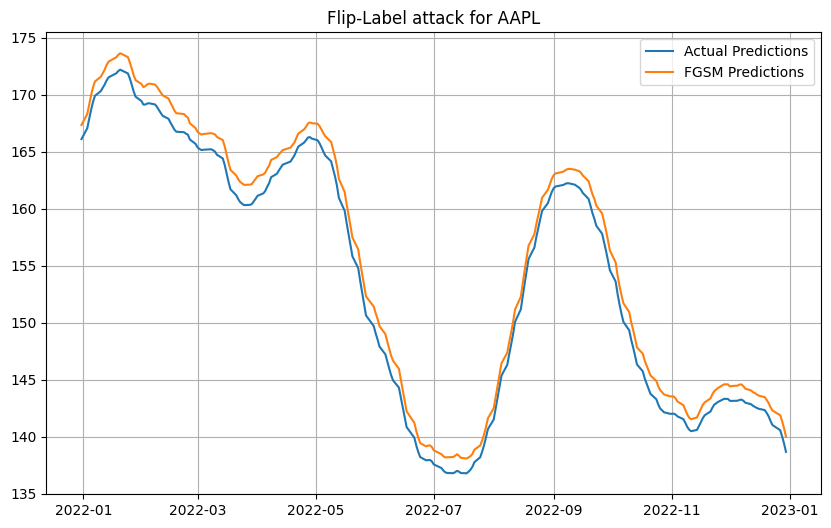

In [4]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

actual_lstm_predictions = "/content/drive/MyDrive/DependableAI/Project/Data/actual_predictions/AAPL_actual_predictions.pickle"
fgsm_predictions        = "/content/drive/MyDrive/DependableAI/Project/Data/adv_predictions/AAPL_adv_predictions.pickle"

with open(actual_lstm_predictions, "rb") as f:
  actual_pred = pd.DataFrame.from_dict(pickle.load(f), orient='index', columns=['close'])

with open(fgsm_predictions, "rb") as f2:
  fgsm_pred = pd.DataFrame.from_dict(pickle.load(f2), orient='index', columns=['close'])

actual_pred.index = actual_pred.index.to_timestamp()
fgsm_pred.index = fgsm_pred.index.to_timestamp()

# Plot the actual and predicted stock prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(actual_pred, label="Actual Predictions")
plt.plot(fgsm_pred, label='FGSM Predictions')
plt.title('Flip-Label attack for AAPL')
plt.legend()
plt.show()